In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 2) Multi-variable Normal

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

with uncertain inputs: $a$ and $I$

In [3]:
mu_a = .8
sigma_a= .1

mu_I = 8.
sigma_I= 1.2

dist = cp.J(cp.Normal(mu_a,sigma_a), cp.Normal(mu_I,sigma_I))

### a) MC propagation

A full Monte-Carlo simulation of the inputs is done ussing a reduced variance sampling method.

"K"     Korobov             
"R"     (Pseudo-)Random     
"L"     Latin hypercube     
"S"     Sobol               
"H"     Halton              
"M"     Hammersley          

The input sample is propagated through the model

In [4]:
sample_inputs = dist.sample(size=1000,rule='L')
sample_u = np.array([u(x,*in_vars) for in_vars in sample_inputs.T ])

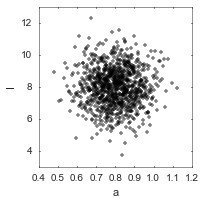

In [5]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')
#ax.set_xticks(np.linspace(-0.05,0.15,5))

fig.tight_layout()
#fig.savefig('Figures/2_2xNormal_NoCorr_MC_sample.pdf')
print

In [6]:
E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

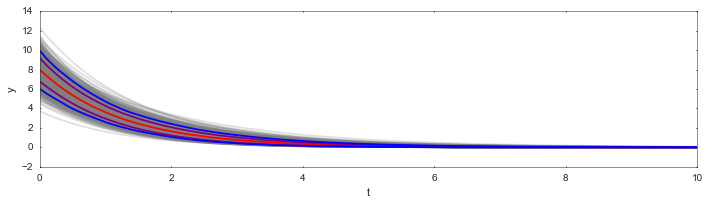

In [7]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_MC.pdf')
print

### b) PCE with Pseudo-spectral collocation

In [8]:
M = 2    # Order of the polynomial
N = M + 1 # Number of terms

Generation of the polynomial basis using the Stiltjes algorithm (three term recursive expression) and the quadrature rule. Pseudo-spectral collocation used based on Gaussian quadrature.

In [9]:
P = cp.orth_ttr(M, dist)
nodes, weights = cp.generate_quadrature(M, dist, rule='G')
print 'nodes'
print nodes

nodes
[[  0.62679492   0.62679492   0.62679492   0.8          0.8          0.8
    0.97320508   0.97320508   0.97320508]
 [  5.92153903   8.          10.07846097   5.92153903   8.          10.07846097
    5.92153903   8.          10.07846097]]


The PCE is computed by projecting the model evaluations in the polynomial basis. 

This requires: 
* P: Polynomial basis
* nodes: location of model evaluations
* weights: weight corresponding to each node in the Gauss quadrature rule
* sample_u_pc: model evaluated at the nodes

In [10]:
samples_u_pc = [u(x,*node) for node in nodes.T]
u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)

In [11]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist), cp.Std(u_hat, dist)

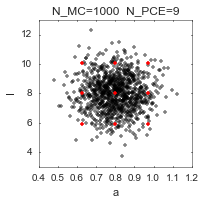

In [12]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes[0,:],nodes[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')
#ax.set_xticks(np.linspace(-0.05,0.15,5))

ax.set_title('N_MC='+str(len(sample_inputs[0,:]))+'  N_PCE='+str(len(nodes[0,:])))

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_MC_sample.pdf')
print

Repeat the MC sample ussing the surrogate model


In [13]:
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_inputs.T ])

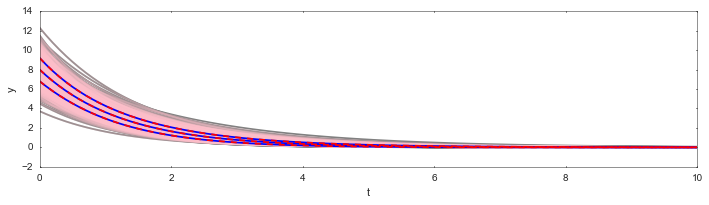

In [14]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_top.pdf')
print

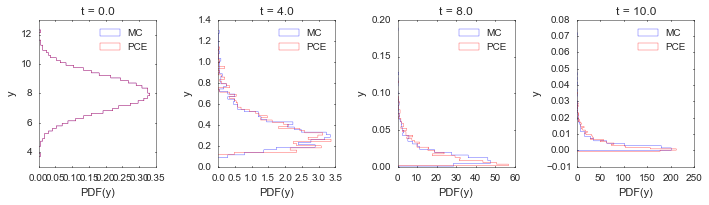

In [15]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_bot.pdf')
print

### Sensitivity analysis by variance decomposition (Sobol's indices)

In [16]:
Sensitivity = cp.Sens_t(u_hat, dist)

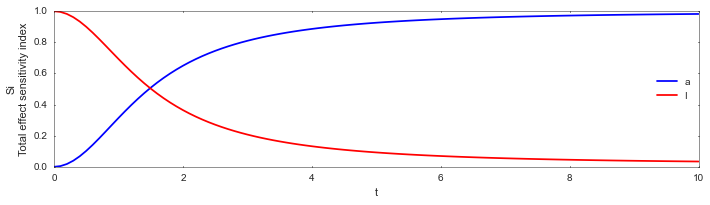

In [17]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_Sens.pdf')

### Convergence

```python
sample_inputs = dist.sample(size=10**6,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
```

In [18]:
M = 8    # Order of the polynomial
P = cp.orth_ttr(M, dist)
nodes, weights = cp.generate_quadrature(M, dist, rule='G')
samples_u_pc = [u(x,*node) for node in nodes.T]
u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)
E_u, Std_u = cp.E(u_hat, dist), cp.Std(u_hat, dist)

In [19]:
def PCE(M):
    # M: Order of the polynomial

    P = cp.orth_ttr(M, dist)
    nodes, weights = cp.generate_quadrature(M, dist, rule='G')
    Npc = len(P)
    print len(P)
    
    samples_u_pc = [u(x,*node) for node in nodes.T]
    u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)

    mean_u_pc, std_u_pc = cp.E(u_hat, dist), cp.Std(u_hat, dist)
    
    
    Error_E = np.trapz(np.abs(E_u - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [20]:
order = range(2,8)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

6
10
15
21
28
36


In [21]:
def MC(Nmc):
    sample_inputs = dist.sample(size=Nmc,rule='H')
    sample_u = np.array([u(x,*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.trapz(np.abs(E_u - E_u_mc)/E_u,x)/10.
    Error_Std_mc = np.trapz(np.abs(Std_u_mc**2./Std_u**2.-1.),x)/10.
    
    return Error_E_mc, Error_Std_mc

In [22]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

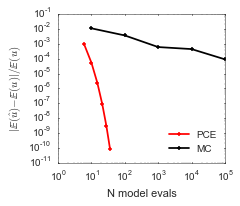

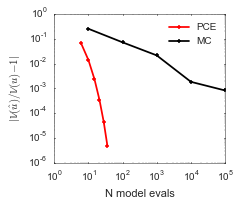

In [23]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc,Error_E,'.-r',label='PCE')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/2_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc,Error_Std,'.-r',label='PCE')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/2_Convergence_V_'+output_name_label+'.pdf')